In [70]:
import numpy as np
import uproot as up
from matplotlib import pyplot as plt, colors
from nustattools.stats import derate_covariance
from scipy.linalg import sqrtm, block_diag

In [2]:
fit_result_file = up.open("genie-tune/result_test_comb_26.root")

In [3]:
fit_result_file.items()

[('param_results;1', <TVectorT<double> (version 4) at 0x7faf91533cd0>),
 ('h_param_result;1', <TH1D (version 2) at 0x7faf915c1fd0>),
 ('param_covariance;1', <TMatrixTSym<double> (version 5) at 0x7faf9153a940>),
 ('global_pred_cov;1', <TMatrixTSym<double> (version 5) at 0x7faf91552160>),
 ('global_pred_MC_err;1', <TH1D (version 2) at 0x7faf915522e0>),
 ('global_pred_sys_err;1', <TH1D (version 2) at 0x7faf91552580>),
 ('h_global_pred_cov;1', <TH2D (version 3) at 0x7faf9155b6a0>),
 ('h_global_pred_cor;1', <TH2D (version 3) at 0x7faf9155e7f0>),
 ('h_param_covariance;1', <TH2D (version 3) at 0x7faf91564e80>),
 ('h_param_correlation;1', <TH2D (version 3) at 0x7faf9136c0a0>)]

In [4]:
param_result = fit_result_file["h_param_result"].values()
param_cov = fit_result_file["h_param_covariance"].values()

In [5]:
print(param_result)
print(np.sqrt(np.diag(param_cov)))

[1.         0.22148547 0.25731855 1.         1.         1.
 1.         1.         1.42566821 1.         0.24964454 2.04553905
 0.15136394 0.01      ]
[0.06884356 0.12023108 0.34075646 0.28200301 0.47710998 0.08367175]


In [6]:
param_names = [
    r"?",
    r"S^pi0_lambda",
    r"S^pi_CEX",
    r"?",
    r"?",
    r"?",
    r"?",
    r"?",
    r"S^N_CEX",
    r"?",
    r"S^N_ABS",
    r"S^N_PIPD",
    r"R_SRC",
    r"?",
]

In [7]:
param_used = [s != "?" for s in param_names]

In [8]:
data_file = up.open("genie-tune/data_ppp.root")

In [9]:
data_file.items()

[('global;1', <TH1D (version 3) at 0x7faf913925e0>),
 ('global_cov;1', <TMatrixTSym<double> (version 5) at 0x7faf914b3c40>),
 ('h_global_cov;1', <TH2D (version 4) at 0x7faf9149bfa0>),
 ('h_global_cor;1', <TH2D (version 4) at 0x7faf914a4160>)]

In [10]:
data_cov = data_file["h_global_cov"].values()
data_cor = data_file["h_global_cor"].values()
data_cov = (data_cov + data_cov.T) / 2
data_cor = (data_cor + data_cor.T) / 2
data_cor.shape

(269, 269)

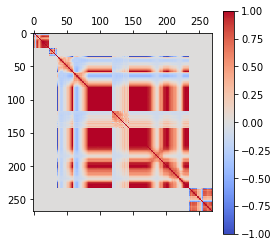

In [71]:
plt.matshow(data_cor, norm=colors.CenteredNorm(), cmap="coolwarm")
plt.colorbar()

In [12]:
np.where(data_cov> 5e-2)

(array([  0,  24,  36, 235, 235, 255]), array([  0,  24,  36, 235, 255, 235]))

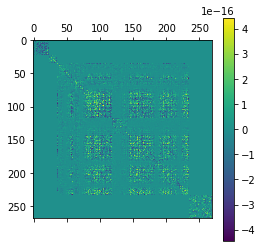

In [13]:
def cov_to_cor(cov):
    sigma = np.sqrt(np.diag(cov))
    cor = cov / sigma[np.newaxis, :] / sigma[:, np.newaxis]
    return cor
plt.matshow(cov_to_cor(data_cov) - data_cor)
plt.colorbar()

In [14]:
blocks = []
cor = data_cor
while len(cor):
    i = np.where(cor[0] == 0)[0]
    if len(i) == 0:
        blocks.append(len(cor))
        break
    else:
        blocks.append(i[0])
        cor = cor[i[0] :, :][:, i[0] :]

del cor

In [15]:
blocks

[24, 12, 199, 34]

In [16]:
i = 0
k = np.sum(blocks)
for j, n in enumerate(sorted(blocks)[::-1]):
    i += (j + 1) * n
i /= k
np.sqrt(1 + 120 * (i - np.sqrt(i)) / (k + 25))

1.0476834427019623

In [17]:
data_cov_nan = np.full_like(data_cov, np.nan)
data_cor_nan = np.full_like(data_cor, np.nan)
i = 0
for b in blocks:
    data_cov_nan[i : i + b, :][:, i : i + b] = data_cov[i : i + b, :][:, i : i + b]
    data_cor_nan[i : i + b, :][:, i : i + b] = data_cor[i : i + b, :][:, i : i + b]
    i += b

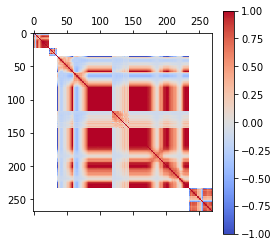

In [18]:
plt.matshow(data_cor_nan, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [19]:
np.nanmax(np.abs(data_cor_nan - data_cor_nan.T))

0.0

In [20]:
ret = {}
a = derate_covariance(
    data_cor_nan, return_dict=ret, whitening="zca_aligned"
)
a

1.0934172861310973

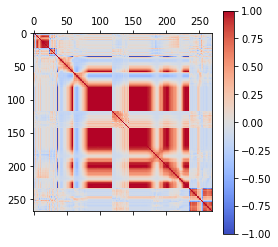

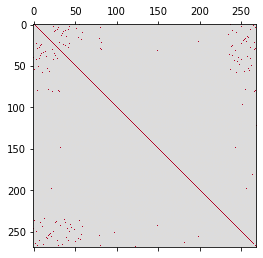

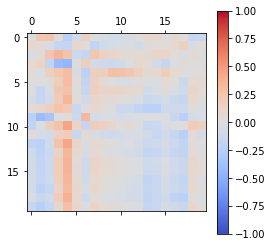

In [51]:
c = ret["nightmare_cov"]
plt.matshow(c, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
W = ret["W"]
plt.matshow((W @ c @ W.T), vmin=-1, vmax=1, cmap="coolwarm")
plt.matshow(c[:20, -20:], vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [22]:
ret0 = {}
a = derate_covariance(
    data_cov_nan, return_dict=ret0, whitening="zca_aligned"
)
a

1.0943189935891184

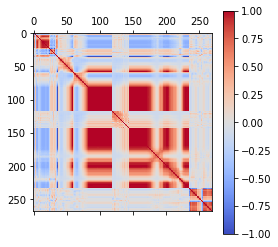

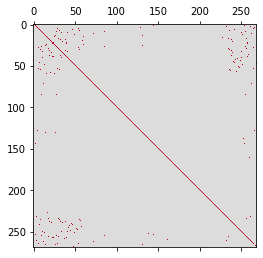

In [41]:
c = ret0["nightmare_cov"]
cor = cov_to_cor(c)
plt.matshow(cor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
W = ret0["W"]
plt.matshow((W @ c @ W.T), vmin=-1, vmax=1, cmap="coolwarm")

In [24]:
%%time
derate_covariance(data_cov_nan, whitening="cholesky")

CPU times: user 4.62 s, sys: 1.67 s, total: 6.29 s
Wall time: 4.06 s


1.0943013389962006

In [25]:
derate_covariance(data_cov_nan, whitening="zca_aligned", method="gx2")

1.0943189935891184

In [26]:
A = np.loadtxt("genie-tune/jacobian.dat")[:, param_used]

In [27]:
A.shape

(269, 6)

In [28]:
A[0]

array([-0.06346964, -0.11234684,  0.02089782, -0.15379777, -0.00546241,
       -0.42687375])

In [29]:
data_used_red = []
with open("genie-tune/data_no_syst.weight_26", "rt") as f:
    for line in f:
        if line.startswith("/global#"):
            field = line.split()
            imin, imax = field[0].split("#")[1].split(":")
            used = float(field[1]) > 0.5
            for _ in range(int(imin), int(imax)):
                data_used_red.append(used)
data_used_red = np.array(data_used_red)
print(len(data_used_red), np.sum(data_used_red))

269 98


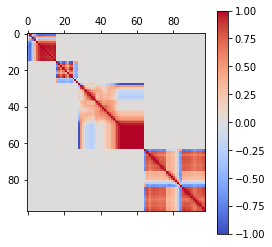

In [30]:
data_cov_red = data_cov_nan[data_used_red,:][:,data_used_red]
data_cor_red = data_cor[data_used_red,:][:,data_used_red]
plt.matshow(data_cor_red, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [31]:
ret_red = {}
derate_covariance(data_cov_red, jacobian=A[data_used_red], return_dict=ret_red)

2.2291232365240448

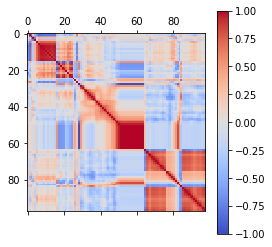

In [49]:
nightmare_cor_red = cov_to_cor(ret_red["nightmare_cov"])
plt.matshow(nightmare_cor_red, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [33]:
full_fit_result_file = up.open("genie-tune/result_test_comb_15.root")

In [34]:
full_fit_result_file.items()

[('param_results;1', <TVectorT<double> (version 4) at 0x7faf8a976190>),
 ('h_param_result;1', <TH1D (version 2) at 0x7faf8a9766d0>),
 ('param_covariance;1', <TMatrixTSym<double> (version 5) at 0x7faf8a976280>),
 ('global_pred_cov;1', <TMatrixTSym<double> (version 5) at 0x7faf89116f10>),
 ('global_pred_MC_err;1', <TH1D (version 2) at 0x7faf8911b130>),
 ('global_pred_sys_err;1', <TH1D (version 2) at 0x7faf8911b3d0>),
 ('h_global_pred_cov;1', <TH2D (version 3) at 0x7faf8911f520>),
 ('h_global_pred_cor;1', <TH2D (version 3) at 0x7faf89124670>),
 ('h_param_covariance;1', <TH2D (version 3) at 0x7faf8912b850>),
 ('h_param_correlation;1', <TH2D (version 3) at 0x7faf89131a30>)]

In [35]:
full_param_result = full_fit_result_file["h_param_result"].values()
full_param_cov = full_fit_result_file["h_param_covariance"].values()

In [36]:
full_param_result

array([1.10836403, 0.17212304, 1.53233169, 0.6706714 , 1.58794822,
       0.90426555, 1.1191042 , 1.19606893, 1.41223647, 1.26262667,
       0.28092843, 1.26716833, 0.30149474, 0.01131865])

In [37]:
B = np.loadtxt("genie-tune/full_jacobian.dat")

In [38]:
data_used_full = []
with open("genie-tune/data_no_syst.weight_15", "rt") as f:
    for line in f:
        if line.startswith("/global#"):
            field = line.split()
            imin, imax = field[0].split("#")[1].split(":")
            used = float(field[1]) > 0.5
            for _ in range(int(imin), int(imax)):
                data_used_full.append(used)
data_used_full = np.array(data_used_full)
print(len(data_used_full), np.sum(data_used_full))

269 72


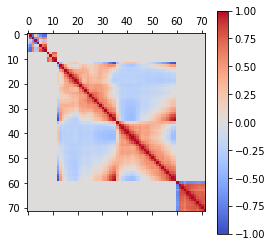

In [39]:
data_cov_full = data_cov_nan[data_used_full,:][:,data_used_full]
data_cor_full = data_cor[data_used_full,:][:,data_used_full]
plt.matshow(data_cor_full, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [45]:
ret_full = {}
derate_covariance(data_cov_full, jacobian=B[data_used_full], return_dict=ret_full)

1.4581963394550412

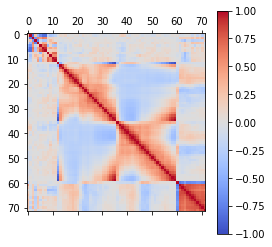

In [48]:
nightmare_cor_full = cov_to_cor(ret_full["nightmare_cov"])
plt.matshow(nightmare_cor_full, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [53]:
raw_data_file = up.open("genie-tune/data_no_syst.root")

In [54]:
raw_data_file.items()

[('global;1', <TH1D (version 3) at 0x7faf889e3df0>),
 ('global_cov;1', <TMatrixTSym<double> (version 5) at 0x7faf91597820>),
 ('h_global_cov;1', <TH2D (version 4) at 0x7faf83dee490>),
 ('h_global_cor;1', <TH2D (version 4) at 0x7faf88e11670>)]

In [ ]:
raw_data_cor = raw_data_file["h_global_cor"]

In [55]:
raw_data_cov = raw_data_file["h_global_cov"].values()
raw_data_cor = raw_data_file["h_global_cor"].values()
raw_data_cov = (raw_data_cov + raw_data_cov.T) / 2
raw_data_cor = (raw_data_cor + raw_data_cor.T) / 2
raw_data_cor.shape

(269, 269)

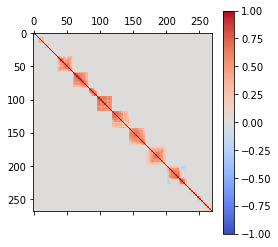

In [56]:
plt.matshow(raw_data_cor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [58]:
raw_data_file["global"].values()[:blocks[0]].sum()

3.71299215761779

In [59]:
data_file["global"].values()[0]

3.7129921576177893

In [95]:
i = 0
for b in blocks:
    n = raw_data_file["global"].values()[i:i+b].sum()
    print(n)
    print(raw_data_file["global"].values()[i+1] / n)
    print(raw_data_file["global"].values()[i+b-1] / n)
    i += b

3.71299215761779
0.19082300722000706
0.01750346221234292
3.7470071877961195
0.020708691265993204
0.21852008435058898
237.97042010329994
0.0035027420619678984
4.002736977085293e-07
83.98333600000001
0.015807778819360067
0.0037253938090766004


In [96]:
i = 0
for b in blocks:
    print(data_file["global"].values()[i])
    print(data_file["global"].values()[i+1])
    print(data_file["global"].values()[i+b-1])
    i += b

3.7129921576177893
0.19082300722000708
0.01750346221234292
3.7470071877961195
0.020708691265993204
0.21852008435058898
237.97042010330014
0.0035027420619678953
4.002736977085289e-07
83.98333600000002
0.015807778819360064
0.0037253938090765996


In [88]:
raw_data = raw_data_file["global"].values()
norm_shape_jacobian_list = []
i = 0
for b in blocks:
    dat = raw_data[i:i+b]
    norm = np.sum(dat)
    jac = np.zeros((b,b))
    for j in range(b):
        for k in range(b):
            if j == 0:
                jac[j,k] = 1
            else:
                jac[j,k] = (j==k)/norm - dat[j]/norm**2
    norm_shape_jacobian_list.append(jac)
    i += b

norm_shape_jacobian = block_diag(*norm_shape_jacobian_list)

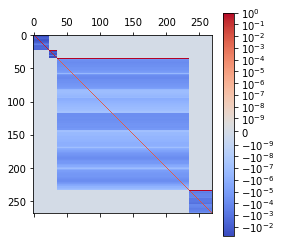

In [89]:
plt.matshow(norm_shape_jacobian, norm=colors.SymLogNorm(linthresh=1e-9), cmap="coolwarm")
plt.colorbar()

In [90]:
test = norm_shape_jacobian @ raw_data
print(test - data_file["global"].values())

[ 4.44089210e-16 -1.90823007e-01 -7.48676813e-02 -1.07504722e-01
 -7.59826706e-02 -2.87839007e-02 -2.00011073e-02 -4.26330598e-03
 -7.17019486e-02 -9.23630768e-02 -5.54255096e-02 -4.77767117e-02
 -2.44278393e-02 -1.24149153e-02 -4.81261544e-03 -1.44190792e-03
 -7.95456830e-03 -1.06684947e-02 -1.46927744e-02 -1.18440265e-02
 -1.05957426e-02 -1.31449592e-02 -1.15283968e-02 -1.75034622e-02
  4.44089210e-16 -2.07086913e-02 -1.11256739e-01 -1.83764121e-02
 -8.00567443e-03 -9.53885600e-02 -8.78127302e-02 -2.59086173e-02
 -1.62516104e-03 -2.07628208e-01 -1.96123947e-01 -2.18520084e-01
 -1.42108547e-13 -3.50274206e-03 -7.99313629e-03 -1.26560688e-02
 -1.60714512e-02 -1.74069533e-02 -1.96831186e-02 -2.11035893e-02
 -1.59837092e-02 -1.27683516e-02 -1.08628627e-02 -1.08257572e-02
 -1.13594370e-02 -1.11304170e-02 -8.15782062e-03 -6.94951919e-03
 -6.62708415e-03 -6.85177594e-03 -5.23695340e-03 -4.79231830e-03
 -3.70419567e-03 -1.95437735e-03 -6.81992325e-04 -6.64822123e-05
 -4.52388158e-03 -1.07390

In [97]:
test_cov = norm_shape_jacobian @ raw_data_cov @ norm_shape_jacobian.T
test_cor = cov_to_cor(test_cov)

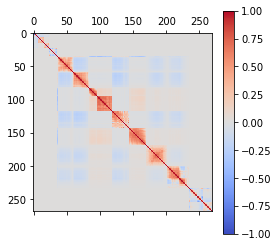

In [98]:
plt.matshow(test_cor, norm=colors.CenteredNorm(), cmap="coolwarm")
plt.colorbar()